In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/gilbutITbook/080289.git 

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 30 (delta 3), pack-reused 2246
Receiving objects: 100% (2278/2278), 330.27 MiB | 29.50 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.


In [ ]:
import os
import time
import glob
import cv2
import shutil
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as  transforms
from torch.utils.data import DataLoader 


In [ ]:
data_path = '/content/080289/chap05/data/catanddog/train'
transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(
    root = data_path ,
    transform = transform
)
train_loader = DataLoader(dataset = train_dataset , batch_size = 32 , num_workers=2, shuffle=True)
print(len(train_dataset))

385


In [ ]:
len(glob.glob(data_path+'/Cat/*.jpg')) , len(glob.glob(data_path+'/Dog/*.jpg') ,)

(182, 203)

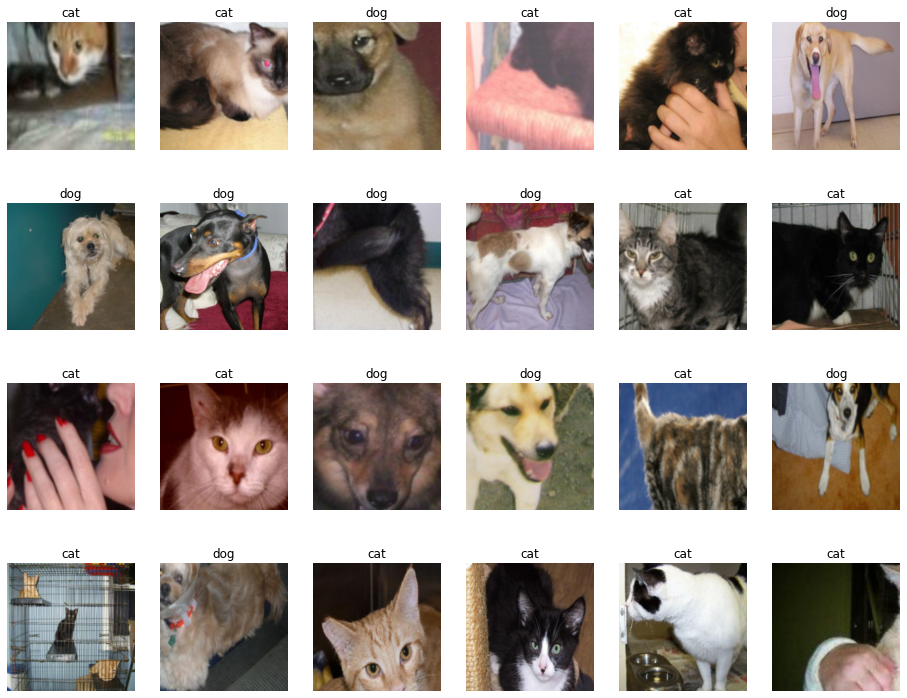

In [ ]:
import matplotlib.pyplot as plt
nrows , ncols = 4,6
classes = {0:"cat" , 1:"dog"}
fig = plt.figure(figsize = (16,24))
imgs , labels = next(iter(train_loader))
for i in range(24):
  a = fig.add_subplot(nrows , ncols , i+1)
  a.set_title(classes[labels[i].item()])
  a.axis("off")
  a.imshow(imgs[i].permute(1,2,0).numpy()) 
plt.subplots_adjust(bottom=0.2 , top=0.6 )
 

## 사전 훈련 모델 받기

In [ ]:
resnet18 = torchvision.models.resnet18(weights = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
for param in resnet18.parameters():
  param.requires_grad = False

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = nn.Linear(512,2)

In [ ]:
for name , param in resnet18.named_parameters():
  if param.requires_grad:
    print(name , param.data)
    print(param.data.shape)

fc.weight tensor([[-0.0307,  0.0272, -0.0371,  ...,  0.0243,  0.0043,  0.0373],
        [-0.0022,  0.0037, -0.0293,  ..., -0.0109, -0.0438, -0.0254]])
torch.Size([2, 512])
fc.bias tensor([-0.0314,  0.0145])
torch.Size([2])


In [ ]:
model = torchvision.models.resnet18(weights = True)

for param in model.parameters():
  param.requires_grad = False # 모델 가중치 고정

model.fc = nn.Linear(512,2)

for param in model.fc.parameters():
  param.requires_grad = True

params_to_update = []
for name , param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print('\t',name , param)
optimizer = optim.Adam(params_to_update) 

# optimizer = optim.Adam(params = model.fc.parameters()) # 업데이트 할 가중치만 대입




	 fc.weight Parameter containing:
tensor([[ 0.0194, -0.0337, -0.0392,  ...,  0.0075,  0.0086,  0.0342],
        [-0.0070,  0.0430, -0.0422,  ..., -0.0163,  0.0063, -0.0123]],
       requires_grad=True)
	 fc.bias Parameter containing:
tensor([-0.0321, -0.0421], requires_grad=True)


## 모델 학습

In [ ]:
def train_model(model , dataloader , criterion , optimizer , device , epochs , is_train = True):
  start = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0 

  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch , epochs-1))
    print('-'*10)
    running_loss = 0.0
    running_corrects = 0

    for img , label in dataloader:

      # 예측
      img , label = img.to(device) , label.to(device)
      model.to(device)
      
      output = model.forward(img)
      

      # 정확도 , loss 계산
      optimizer.zero_grad()
      loss = criterion(output , label)
      predicted = torch.max(output , axis = 1)[1]
   
      # print(predicted , predicted.shape , type(predicted))
      # print(label , label.shape , type(label))
      # print(loss)
      

      # 기울기 초기화 및 역전파 수행
      loss.backward()
      optimizer.step()

      # 결과치 저장
      running_loss += loss.item()
      running_corrects += torch.sum(label == predicted).item()

    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
   
    
    acc_history.append(epoch_acc)
    loss_history.append(epoch_loss)
    print("Loss : {:.4f} ACC: {:.4f}".format(epoch_loss , epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc
    if not os.path.exists('/content/config'):
      os.mkdir('/content/config/')
    torch.save(model.state_dict() , os.path.join('/content/config' ,'{0:02d}.pth'.format(epoch)))
    print('model save!')

  
  end = time.time()-start
  print('Traning complete in {:.0f}m {:.0f}s'.format(end //60, end % 60))
  print('Best ACC : {:.4f}'.format(best_acc))
  return acc_history , loss_history

  

    


      


## 파라미터 학습 결과를 옵티마이저에 전달

In [ ]:
img , label = next(iter(train_loader))


## 모델 학습

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
train_acc_hist , train_loss_hist = train_model(model , train_loader , criterion , optimizer , device , 13 )

Epoch 0/12
----------
Loss : 0.0220 ACC: 0.6701
model save!
Epoch 1/12
----------
Loss : 0.0149 ACC: 0.8182
model save!
Epoch 2/12
----------
Loss : 0.0122 ACC: 0.8597
model save!
Epoch 3/12
----------
Loss : 0.0097 ACC: 0.8857
model save!
Epoch 4/12
----------
Loss : 0.0096 ACC: 0.9013
model save!
Epoch 5/12
----------
Loss : 0.0092 ACC: 0.9247
model save!
Epoch 6/12
----------
Loss : 0.0091 ACC: 0.9039
model save!
Epoch 7/12
----------
Loss : 0.0080 ACC: 0.9247
model save!
Epoch 8/12
----------
Loss : 0.0104 ACC: 0.8935
model save!
Epoch 9/12
----------
Loss : 0.0098 ACC: 0.9039
model save!
Epoch 10/12
----------
Loss : 0.0070 ACC: 0.9195
model save!
Epoch 11/12
----------
Loss : 0.0082 ACC: 0.9065
model save!
Epoch 12/12
----------
Loss : 0.0093 ACC: 0.8961
model save!
Traning complete in 0m 45s
Best ACC : 0.9247


In [ ]:
train_acc_hist , train_loss_hist

([0.6701298701298701,
  0.8181818181818182,
  0.8597402597402597,
  0.8857142857142857,
  0.9012987012987013,
  0.9246753246753247,
  0.9038961038961039,
  0.9246753246753247,
  0.8935064935064935,
  0.9038961038961039,
  0.9194805194805195,
  0.9064935064935065,
  0.8961038961038961],
 [0.021998926184394144,
  0.014949751055085813,
  0.012189820486229736,
  0.009685684798599837,
  0.009573448594514426,
  0.009154432779782779,
  0.009109854427250949,
  0.00796517493662896,
  0.010431691713921436,
  0.009848641439691767,
  0.006960693930650686,
  0.008191571723331105,
  0.009299706522520487])

## 테스트 데이터 호출 및 전처리

In [ ]:
test_path = "/content/080289/chap05/data/catanddog/test"

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(test_path , transform = transform)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset , batch_size = 32 , shuffle = True ,num_workers=0 )
print(len(test_loader) , len(test_dataset) , len(test_loader.dataset) , f'batch_size : {test_loader.batch_size}')

4 98 98 batch_size : 32


## 테스트 데이터 평가 함수 생성

In [ ]:
def eval_model(model , dataloader , device):
  start = time.time()
  acc_hist = []
  best_acc = 0.0

  saved_models = glob.glob('/content/config/*.pth')
  saved_models.sort()
  print('save_models' , saved_models)
  for model_path in saved_models:
    print('Loading model:' , model_path)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    running_corrects = 0

    for img , label in dataloader:

     
      img , label = img.to(device) , label.to(device)
      # print(img.dtype , label.dtype)
      with torch.no_grad():
        output = model(img)
      

      
      _, predicted = torch.max(output , axis = 1)
      # print(predicted.get_device() , predicted.dtype)
      running_corrects += predicted.eq(label).int().sum()
    epoc_acc = running_corrects / len(dataloader.dataset)
    print("ACC : {:.4f}".format(epoc_acc))

    if epoc_acc > best_acc:
      best_acc = epoc_acc
    acc_hist.append(epoc_acc.item())

  end = time.time() - start
  print('Validation complete ! {:.0f}m {:.0f}s'.format(end //60 ,end % 60))
  print('Best ACC : {}'.format(best_acc))
  return acc_hist

In [ ]:
val_acc_hist = eval_model(model , test_loader , device)


save_models ['/content/config/00.pth', '/content/config/01.pth', '/content/config/02.pth', '/content/config/03.pth', '/content/config/04.pth', '/content/config/05.pth', '/content/config/06.pth', '/content/config/07.pth', '/content/config/08.pth', '/content/config/09.pth', '/content/config/10.pth', '/content/config/11.pth', '/content/config/12.pth']
Loading model: /content/config/00.pth
ACC : 0.8367
Loading model: /content/config/01.pth
ACC : 0.8776
Loading model: /content/config/02.pth
ACC : 0.9184
Loading model: /content/config/03.pth
ACC : 0.9082
Loading model: /content/config/04.pth
ACC : 0.9286
Loading model: /content/config/05.pth
ACC : 0.9286
Loading model: /content/config/06.pth
ACC : 0.9286
Loading model: /content/config/07.pth
ACC : 0.9184
Loading model: /content/config/08.pth
ACC : 0.9388
Loading model: /content/config/09.pth
ACC : 0.9694
Loading model: /content/config/10.pth
ACC : 0.9082
Loading model: /content/config/11.pth
ACC : 0.9592
Loading model: /content/config/12.pth

In [ ]:
val_acc_hist

[0.8367346525192261,
 0.8775510191917419,
 0.918367326259613,
 0.9081632494926453,
 0.9285714030265808,
 0.9285714030265808,
 0.9285714030265808,
 0.918367326259613,
 0.9387754797935486,
 0.9693877100944519,
 0.9081632494926453,
 0.9591836333274841,
 0.9387754797935486]

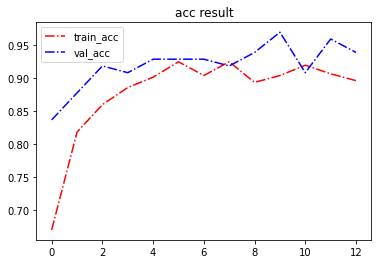

In [ ]:
plt.plot(train_acc_hist , '-.r', val_acc_hist , '-.b')
plt.title("acc result")
plt.legend(['train_acc' , 'val_acc'])

In [ ]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image.clip(0,1)
  return image


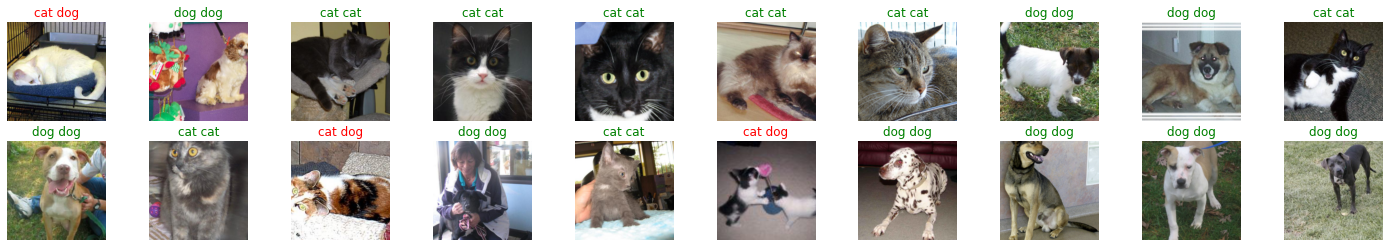

In [ ]:
classes = {0:"cat" , 1:'dog'}
dataiter = iter(test_loader)
images , labels = next(dataiter)
model.to('cpu')
output = model(images)
_ , preds = torch.max(output , 1)

fig = plt.figure(figsize = (25,4))
for idx in range(20):
  ax = fig.add_subplot(2,10 , idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.axis('off')
  ax.set_title('{} {}'.format(classes[labels[idx].item()] , classes[preds[idx].item()])  , color = "green" if classes[labels[idx].item()] == classes[preds[idx].item()] else 'red')

  


## Feature map 시각화

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [ ]:
model = XAI()
model.to('cpu')
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [ ]:
class LayerActivations:
  fetures = []
  def __init__(self , model , layer_num):
    self.hook = model[layer_num].register_forward_hook(self.hook_fn)

  def hook_fn(self , module , input , output):
    self.features = output.detach().numpy()

  def remove(self):
    self.hook.remove()

In [ ]:
ㅠ